In [1]:
import math
import numpy as np
import tbplas as tb
import sisl
from pathlib import Path

/home/alapena/miniconda3/envs/tbplas/lib/python3.12/site-packages/tbplas/cython/__init__.py:54: UserWarning: C++ hdf5 extension not found. HDF5 IO not usable.
  warnings.warn("C++ hdf5 extension not found. HDF5 IO not usable.")


In [2]:
def add_orbitals(cell: tb.PrimitiveCell, positions, onsites, labels) -> None:
    """
    Add orbitals to the model.

    There are n_atoms atoms, with n_orbs orbitals each in that same position. We will extract those orbitals from the atom info.
    """
    for i in range(positions.shape[0]):
        n_orbs = len(labels[i])
        for j in range(n_orbs):
            cell.add_orbital_cart(positions[i], unit=tb.ANG, energy=onsites[i*n_orbs+j], label=labels[i][j])


def add_hopping_terms(cell: tb.PrimitiveCell, iscs, orbs_in, orbs_out, hoppings) -> None:
    n_hops = len(iscs)
    for i in range(n_hops):
        cell.add_hopping(rn=iscs[i], orb_i=orbs_in[i], orb_j=orbs_out[i], energy=hoppings[i])

In [3]:
debug_mode=False

path = Path("../../dataset/SHARE_OUTPUTS_2_ATOMS/7bbb-6d51-41eb-9de4-329298202ebf")
file = sisl.get_sile(path / "aiida.HSX")
geometry = file.read_geometry()

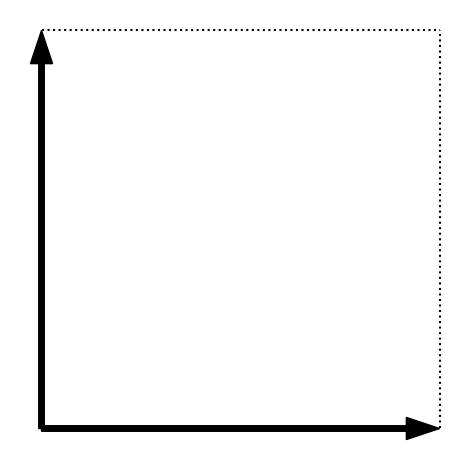

In [4]:
# Define tight binding model for tbplas

# Empty cell
vectors = geometry.cell
cell = tb.PrimitiveCell(vectors, unit=tb.ANG)
cell.plot()

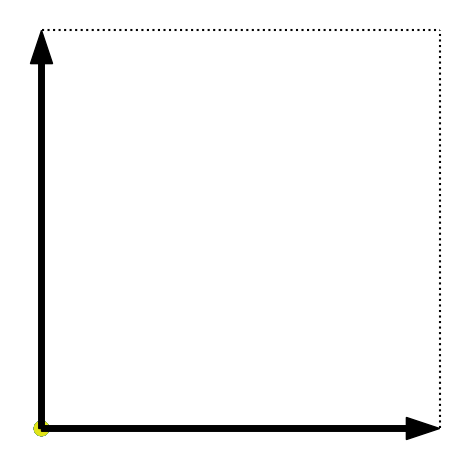

In [5]:
# Add orbitals
positions = geometry.xyz #Angstrom
labels = [[orb.name() for orb in atom] for atom in geometry.atoms]

# To add the orbitals we need the onsite energies.
h = file.read_hamiltonian()
h_mat = h.tocsr().tocoo()

rows = h_mat.row
cols = h_mat.col
data = h_mat.data

# Main diagonal length:
n_diag = min(h_mat.shape[0], h_mat.shape[1])

# Loop through all diagonal elements
onsites = np.zeros(n_diag, dtype=data.dtype)
for i in range(n_diag):
    # Find where both row and col equal i
    mask = (rows == i) & (cols == i)
    vals = data[mask]
    if len(vals) > 0:
        onsites[i] = vals[0]  # In COO, there could be duplicates, but take the first
    else:
        onsites[i] = 0  # Or np.nan if you prefer

# onsites = 
add_orbitals(cell, positions, onsites, labels)
cell.plot()

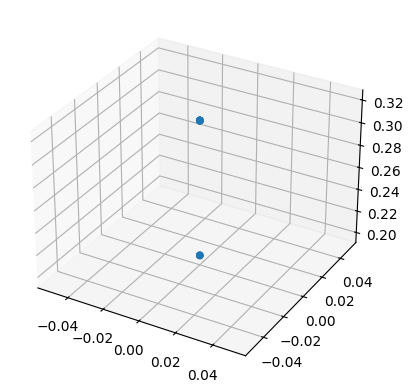

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

positions = cell.orb_pos_nm  # (N, 3) numpy array of orbital coordinates
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(positions[:,0], positions[:,1], positions[:,2])
plt.show()


In [7]:
print("Plotting structure...")
file = sisl.get_sile(path / "aiida.fdf")
fig = file.plot.geometry(axes="xyz")
# filepath = savedir_struct / f"{n_atoms}atm_{structure}.png"
# fig.write_image(str(filepath))
fig.show()
file.read_geometry().atoms.Z

Plotting structure...


array([5, 5], dtype=int32)

In [8]:
import plotly.graph_objects as go

positions = cell.orb_pos_nm  # (N, 3) numpy array of orbital coordinates

fig = go.Figure(data=[go.Scatter3d(
    x=positions[:, 0],
    y=positions[:, 1],
    z=positions[:, 2],
    mode='markers',
    marker=dict(size=5, color='blue')
)])

fig.update_layout(
    scene=dict(
        xaxis_title='X (nm)',
        yaxis_title='Y (nm)',
        zaxis_title='Z (nm)'
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)

fig.show()


In [9]:
# Add hopping terms.
# We need to iterate though each nnz element of h and get the isc in a tuple, the orb_in, the orb_out and the hopping value.
nnz = len(data)
n_orbs = len(labels[0]) # Assuming all atoms have the same nr of orbitals
n_atoms = int(path.parts[-2].split("_")[-2])
iscs = []
orbs_in = []
orbs_out = []
hoppings = []
for k in range(nnz):
    row = rows[k]
    col = cols[k]
    if row != col:  # Only add hopping terms for off-diagonal elements
        iscs.append(geometry.o2isc(col))
        orbs_in.append(col % (n_atoms*n_orbs))
        orbs_out.append(row)
        hoppings.append(data[k])
    

add_hopping_terms(cell, iscs, orbs_in, orbs_out, hoppings)
# cell.plot()

In [10]:
# Get overlap

# To add the orbitals we need the onsite energies.
o = file.read_overlap()
o_mat = o.tocsr().tocoo()

rows = o_mat.row
cols = o_mat.col
data = o_mat.data

# Main diagonal length:
n_diag = min(o_mat.shape[0], o_mat.shape[1])

# Loop through all diagonal elements
onsites = np.zeros(n_diag, dtype=data.dtype)
for i in range(n_diag):
    # Find where both row and col equal i
    mask = (rows == i) & (cols == i)
    vals = data[mask]
    if len(vals) > 0:
        onsites[i] = vals[0]  # In COO, there could be duplicates, but take the first
    else:
        onsites[i] = 0  # Or np.nan if you prefer

# Add onsites to overlap
overlap = tb.PrimitiveCell(cell.lat_vec, cell.origin, 1.0)
for i in range(cell.num_orb):
    orbital = cell.orbitals[i]
    overlap.add_orbital(orbital.position, onsites[i])


# Add hopping terms to overlap

# We need to iterate though each nnz element of h and get the isc in a tuple, the orb_in, the orb_out and the hopping value.
nnz = len(data)
n_orbs = len(labels[0]) # Assuming all atoms have the same nr of orbitals
n_atoms = int(path.parts[-2].split("_")[-2])
iscs = []
orbs_in = []
orbs_out = []
hoppings = []
for k in range(nnz):
    row = rows[k]
    col = cols[k]
    if row != col:  # Only add hopping terms for off-diagonal elements
        iscs.append(geometry.o2isc(col))
        orbs_in.append(col % (n_atoms*n_orbs))
        orbs_out.append(row)
        hoppings.append(data[k])
        

add_hopping_terms(overlap, iscs, orbs_in, orbs_out, hoppings)

In [11]:
def real_space_to_kspace(positions, b1, b2, b3):
    """
    Map real-space positions into reciprocal space (fractional and cartesian).
    Returns:
        k_frac: (N, 3) positions in fractional reciprocal coordinates
        k_cart: (N, 3) positions in cartesian k-space (nm^-1)
    """
    B = np.vstack([b1, b2, b3])  # reciprocal lattice vectors (3,3), Ang^-1
    # Fractional reciprocal coordinates
    k_frac = np.linalg.solve(B.T, positions.T).T  # shape (N,3)
    # Cartesian k-vectors
    k_cart = k_frac @ B
    return k_frac, k_cart

b1, b2, b3 = cell.get_reciprocal_vectors()/10 # Angstrom^-1
k_pos_frac, k_pos_cart = real_space_to_kspace(positions, b1, b2, b3)


In [12]:
# Define a path in k-space


# Compute k path
B = np.vstack([b1, b2, b3])  # shape (3,3)
k_cart = np.array([[0.0, 0.0, 0.0], b3])
k_label = [r"$\Gamma$", "Z"]

k_frac = np.array([np.linalg.solve(B.T, k) for k in k_cart])

n_ks = 25
k_path, k_idx = tb.gen_kpath(k_frac, [n_ks for _ in range(len(k_frac) -1)])
len(k_path)

26

In [13]:
import numpy as np
import plotly.graph_objects as go
from scipy.spatial import Voronoi, ConvexHull
import numpy as np
import plotly.graph_objects as go
from scipy.spatial import Voronoi, ConvexHull

def plot_bz_with_kpath_lines(
    b1, b2, b3, 
    k_cart, 
    k_label, 
    extra_scatter=None, 
    scatter_color="blue", 
    scatter_size=6, 
    scatter_name="Extra points"
):
    """
    Plot 3D Brillouin zone, k-path, and optional extra scatter points.
    - cell: TBPLaS cell object
    - k_cart: (N,3) k-point coordinates (in nm^-1)
    - k_label: list of labels for k-points
    - extra_scatter: (M,3) array of additional scatter points in k-space (optional)
    - scatter_color: color for the extra scatter points
    - scatter_size: marker size for the extra scatter points
    - scatter_name: legend label for the extra scatter points
    """
    # BZ construction
    pts = []
    for n1 in range(-1, 2):
        for n2 in range(-1, 2):
            for n3 in range(-1, 2):
                pts.append(n1 * b1 + n2 * b2 + n3 * b3)
    pts = np.array(pts)
    vor = Voronoi(pts)
    origin_index = np.argmin(np.linalg.norm(pts, axis=1))
    region_index = vor.point_region[origin_index]
    region = vor.regions[region_index]
    if -1 in region:
        print("Warning: Brillouin zone is unbounded, try expanding the lattice grid!")
    vertices = np.array([vor.vertices[i] for i in region if i != -1])
    hull = ConvexHull(vertices)

    fig = go.Figure()
    # BZ mesh
    for s in hull.simplices:
        fig.add_trace(go.Mesh3d(
            x=vertices[s, 0], y=vertices[s, 1], z=vertices[s, 2],
            color='lightblue', opacity=0.5, alphahull=0, showlegend=False
        ))
    # BZ vertices
    fig.add_trace(go.Scatter3d(
        x=vertices[:, 0], y=vertices[:, 1], z=vertices[:, 2],
        mode='markers', marker=dict(size=3, color='red'), name='BZ Vertices'
    ))
    # # Gamma point
    # fig.add_trace(go.Scatter3d(
    #     x=[0], y=[0], z=[0],
    #     mode='markers', marker=dict(size=6, color='black', symbol='x'), name=r'Gamma'
    # ))
    # k-path lines+markers
    fig.add_trace(go.Scatter3d(
        x=k_cart[:, 0], y=k_cart[:, 1], z=k_cart[:, 2],
        mode='lines+markers',
        line=dict(color='darkgreen', width=6),
        marker=dict(size=7, color='orange'),
        name='k-path'
    ))
    # Label the special points
    for kpt, label in zip(k_cart, k_label):
        fig.add_trace(go.Scatter3d(
            x=[kpt[0]], y=[kpt[1]], z=[kpt[2]],
            mode='text',
            text=[label],
            textposition='top center',
            showlegend=False
        ))
    # Plot extra scatter points if provided
    if extra_scatter is not None and len(extra_scatter) > 0:
        fig.add_trace(go.Scatter3d(
            x=extra_scatter[:, 0], y=extra_scatter[:, 1], z=extra_scatter[:, 2],
            mode='markers',
            marker=dict(size=scatter_size, color=scatter_color),
            name=scatter_name
        ))
    fig.update_layout(
        scene=dict(
            xaxis_title='kx (nm⁻¹)',
            yaxis_title='ky (nm⁻¹)',
            zaxis_title='kz (nm⁻¹)'
        ),
        margin=dict(l=0, r=0, b=0, t=0),
        title="3D Brillouin Zone with k-point Path"
    )
    fig.show()


def fold_k_to_bz(k_cart, b1, b2, b3):
    """
    Fold cartesian k-points into the first Brillouin zone defined by b1, b2, b3.
    Returns cartesian coordinates in the first BZ.
    """
    B = np.vstack([b1, b2, b3])  # shape (3,3)
    # Fractional coordinates: solve B.T @ frac = k_cart
    frac = np.linalg.solve(B.T, k_cart.T).T
    # Wrap to (-0.5, 0.5]
    frac_bz = (frac + 0.5) % 1.0
    # Back to cartesian
    k_cart_bz = frac_bz @ B
    return k_cart_bz

k_cart_bz = fold_k_to_bz(k_cart, b1, b2, b3)
plot_bz_with_kpath_lines(
    b1, b2, b3,
    k_cart_bz,
    k_label,
    extra_scatter=k_pos_frac,
    scatter_color="blue",
    scatter_size=5,
    scatter_name="Orbitals in k-space"
)


Parallelization details:
  MPI disabled    
  OMP_NUM_THREADS  : n/a   
  MKL_NUM_THREADS  : n/a   

Output details:
  Directory  : ./
  Prefix     : Test

Using Eigen backend for diagonalization.
	 bands :    0.03198


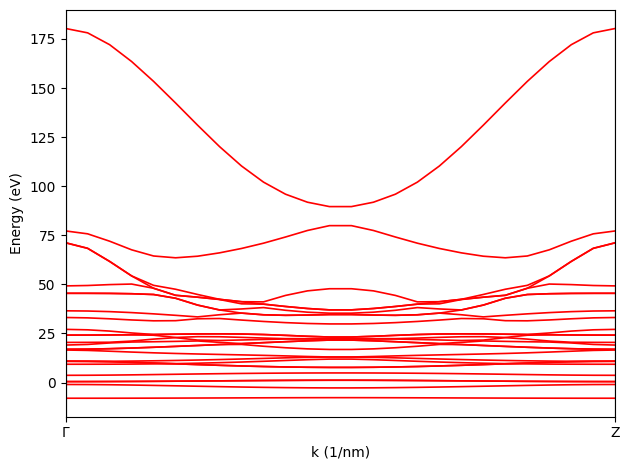

In [14]:
# Calculations


# Bands
use_diag_solver = True
if use_diag_solver:
    solver = tb.DiagSolver(cell, overlap)
    solver.config.k_points = k_path
    solver.config.prefix = "Test"
    solver.config.algo = "gpu"
    timer = tb.Timer()
    timer.tic("bands")
    k_len, bands = solver.calc_bands()
    timer.toc("bands")
else:
    k_len, bands = tb.calc_bands(cell, k_path, prefix="graphene")

vis = tb.Visualizer()
timer.report_total_time()
fig_bands = vis.plot_bands(k_len, bands, k_idx, k_label)



Parallelization details:
  MPI disabled    
  OMP_NUM_THREADS  : n/a   
  MKL_NUM_THREADS  : n/a   

Output details:
  Directory  : ./
  Prefix     : sample

Using Eigen backend for diagonalization.


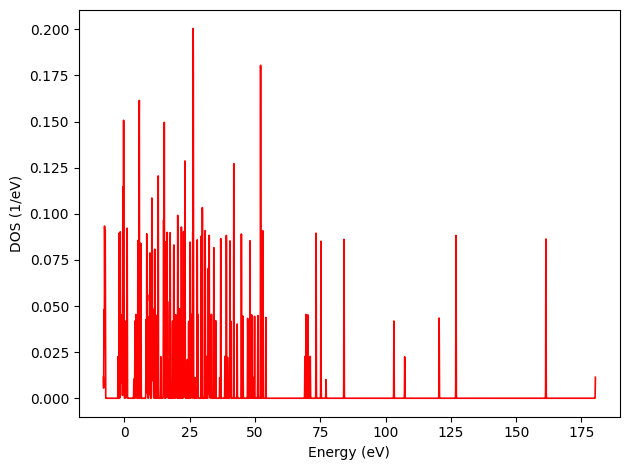

In [15]:
# DOS
n_ks=3
k_mesh = tb.gen_kmesh((n_ks, n_ks, n_ks))  # Uniform meshgrid
e_min = float(np.min(bands))
e_max = float(np.max(bands))

solver = tb.DiagSolver(cell, overlap)
solver.config.k_points = k_mesh
# solver.config.prefix = "graphene"
solver.config.e_min = e_min
solver.config.e_max = e_max
timer = tb.Timer()
timer.tic("dos")
energies, dos = solver.calc_dos()
timer.toc("dos")


vis = tb.Visualizer()
fig_dos = vis.plot_dos(energies, dos)

In [16]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_energy_bands(k_path, array_true, array_pred=None, titles_true=None, titles_pred=None, xlabel=None, ylabel=None, title=None, filepath=None):

    if array_pred.ndim != 2:
        raise ValueError("Input array must be 2-dimensional")

    num_rows = array_pred.shape[0]
    num_cols = array_pred.shape[1]

    # Default color sequence (you can customize this)

    if titles_pred is None:
        titles_pred = [f'Pred Row {i+1}' for i in range(num_rows)]
    elif len(titles_pred) != num_rows:
        raise ValueError("Number of titles_pred must match number of rows")

    if titles_true is None:
        titles_true = [f'True Row {i+1}' for i in range(num_rows)]
    elif len(titles_true) != num_rows:
        raise ValueError("Number of titles_true must match number of rows")



    fig = go.Figure()

    colors = pc.qualitative.Plotly  # or another palette
    num_colors = len(colors)

    for row in range(num_rows):
        color = colors[row % num_colors]

        # Add predicted values as dashed line 
        fig.add_trace(go.Scatter(
            x=k_path,
            y=array_pred[row],
            mode='lines',
            line=dict(dash='dash', color=color),
            name=titles_pred[row],
            # opacity=0.8,
            legendgroup=f'group{row}',
            showlegend=True
        ))

        if array_true is not None:
            # Add true values as solid line with same color 
            fig.add_trace(go.Scatter(
                x=k_path,
                y=array_true[row],
                mode='lines',
                line=dict(dash='solid', color=color),
                name=titles_true[row],
                # opacity=0.8,
                legendgroup=f'group{row}',
                showlegend=True
            ))

    fig.update_layout(
        title=title,
        xaxis_title=xlabel,
        yaxis_title=ylabel,
        # hovermode='x unified',
        height=800,
        xaxis_title_standoff=15,
    )

    fig.update_xaxes(
        showticklabels=False,
    )

    # === Output ===
    if filepath:
        filepath = filepath
        if filepath.suffix.lower() == ".html":
            fig.write_html(str(filepath))
        elif filepath.suffix.lower() == ".png":
            fig.write_image(str(filepath))
        else:
            raise ValueError(f"Unsupported file extension: {filepath.suffix}")
    else:
        fig.show()

    return fig



def plot_bands(k_len, bands, k_idx, k_label, predicted_bands=None, filepath=None):
    """
    Plot band structure using Plotly.

    Parameters:
    - k_len: array-like, k-point distances
    - bands: 2D array, shape (n_kpoints, n_bands), true bands
    - k_idx: list of indices where vertical lines are drawn
    - k_label: list of labels for xticks
    - predicted_bands: optional 2D array, same shape as `bands`
    """
    fig = go.Figure()
    num_bands = bands.shape[1]

    # True bands: solid black
    for i in range(num_bands):
        fig.add_trace(go.Scatter(
            x=k_len,
            y=bands[:, i],
            mode='lines',
            name=f'True Band {i+1}',
            line=dict(color='black', width=1, dash='solid'),
            legendgroup=f'Band {i+1}',
            showlegend=True if predicted_bands is None else False
        ))

    # Predicted bands: dashed black
    if predicted_bands is not None:
        for i in range(num_bands):
            fig.add_trace(go.Scatter(
                x=k_len,
                y=predicted_bands[:, i],
                mode='lines',
                name=f'Predicted Band {i+1}',
                line=dict(color='black', width=1, dash='dash'),
                legendgroup=f'Band {i+1}',
                showlegend=True
            ))

    # Vertical lines
    for idx in k_idx:
        fig.add_shape(type="line",
                      x0=k_len[idx], y0=bands.min(), x1=k_len[idx], y1=bands.max(),
                      line=dict(color="black", width=1))

    # Layout
    fig.update_layout(
        xaxis=dict(
            title="k (1/nm)",
            tickmode='array',
            tickvals=[k_len[i] for i in k_idx],
            ticktext=k_label,
            ticks='',  # Hide tick marks
            showticklabels=True,
            range=[0, k_len.max()]
        ),
        yaxis=dict(title="Energy (eV)"),
        margin=dict(l=50, r=20, t=20, b=50),
        showlegend=True
    )

    # === Output ===
    if filepath is not None:
        if filepath.suffix.lower() == ".html":
            fig.write_html(str(filepath))
        elif filepath.suffix.lower() == ".png":
            fig.write_image(str(filepath), height=1200, width=900,)
        else:
            raise ValueError(f"Unsupported file extension: {filepath.suffix}")
        
    else:
        fig.show()

    return fig



def plot_dos(energies, dos, predicted_dos=None, filepath=None):
    """
    Plot Density of States (DOS) vertically with Energy on y-axis.

    Parameters:
    - energies: array-like, energy values (eV)
    - dos: array-like, true DOS values
    - predicted_dos: optional array-like, predicted DOS values (same shape as dos)
    """
    fig = go.Figure()

    # True DOS
    fig.add_trace(go.Scatter(
        x=dos,
        y=energies,
        mode='lines',
        name='True',
        line=dict(color='black', width=1, dash='solid')
    ))

    # Predicted DOS
    if predicted_dos is not None:
        fig.add_trace(go.Scatter(
            x=predicted_dos,
            y=energies,
            mode='lines',
            name='Pred',
            line=dict(color='black', width=1, dash='dash')
        ))

    # Layout
    fig.update_layout(
        xaxis=dict(title='DOS (1/eV)'),
        yaxis=dict(title='Energy (eV)'),
        margin=dict(l=50, r=50, t=20, b=20),
        showlegend=True
    )

    # === Output ===
    if filepath is not None:
        if filepath.suffix.lower() == ".html":
            fig.write_html(str(filepath))
        elif filepath.suffix.lower() == ".png":
            fig.write_image(str(filepath), height=1200, width=900,)
        else:
            raise ValueError(f"Unsupported file extension: {filepath.suffix}")
        
    else:
        fig.show()

    return fig


def combine_band_and_dos(fig_band, fig_dos, filepath=None):
    """
    Combine band structure and DOS plots side by side into a single figure.

    Parameters:
    - fig_band: Plotly figure from plot_bands()
    - fig_dos: Plotly figure from plot_dos()

    Returns:
    - Combined Plotly figure
    """
    # Create 1-row, 2-column subplot
    fig = make_subplots(rows=1, cols=2, shared_yaxes=True,
                        column_widths=[0.75, 0.25],
                        horizontal_spacing=0.02,
                        specs=[[{"type": "xy"}, {"type": "xy"}]])

    # Add band traces to subplot (1,1)
    for trace in fig_band.data:
        fig.add_trace(trace, row=1, col=1)

    # Add DOS traces to subplot (1,2)
    for trace in fig_dos.data:
        fig.add_trace(trace, row=1, col=2)

    # Update layout
    fig.update_layout(
        xaxis=dict(title='k (1/nm)'),  # subplot (1,1)
        xaxis2=dict(title='DOS (1/eV)'),  # subplot (1,2)
        yaxis=dict(title='Energy (eV)'),  # shared y-axis
        showlegend=True,
        margin=dict(l=50, r=20, t=20, b=40)
    )

    # === Output ===
    if filepath is not None:
        if filepath.suffix.lower() == ".html":
            fig.write_html(str(filepath))
        elif filepath.suffix.lower() == ".png":
            fig.write_image(str(filepath), height=1200, width=900,)
        else:
            raise ValueError(f"Unsupported file extension: {filepath.suffix}")
        
    else:
        fig.show()

    return fig

In [17]:
# filepath = savedir_struct / f"{n_atoms}atm_{structure}_bands.html"
fig_bands = plot_bands(k_len, bands, k_idx, k_label, predicted_bands=None, filepath=None)
# filepath = savedir_struct / f"{n_atoms}atm_{structure}_dos.html"
fig_dos = plot_dos(energies, dos, predicted_dos=None, filepath=None)
# filepath = savedir_struct / f"{n_atoms}atm_{structure}_bandsdos.html"
combine_band_and_dos(fig_bands, fig_dos, filepath=None)
None

# AC Conductivity

In [18]:
# Fermi from Thomas:

import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt


#Find the "Fermi Energy" from the DOS
def FindFermi2(energies, dos, N_orbitals, N_electrons, mode='linear', ShowPlot=False):
    """
    Estimates from the DOS the lowest energy E_Fermi such that the total number of states below E_Fermi is equal to the number of filled states. Expects a spinless calculation.
    INPUTS:
    energies, np.array of floats: the energies for which the DOS was computed.
    dos, np.array of floats: the corresponding dos values.
    N_orbitals: the total number of orbitals in the system (e.g. 12 per atom in a typical SIESTA calculation)
    N_electrons: the total number of electrons in the system (so in a typical BN calculation without spin, 3 per B atom and 5 per N atom)
    mode, string: see code. One would expect linear is to be better usually.
    showPlot, bool: if True, displays a plot showing graphically the determination of E_Fermi.
    OUTPUTS:
    E_Fermi: estimate of the lowest energy such that the total number of states below that energy is equal to the number of filled states.
    """

    cross_val=N_electrons/2  #number of filled SPINLESS states.

    cum_int=integrate.cumulative_trapezoid(dos, energies, initial=0)  #cumulative integral providing (possibly up to normalization) the number of filled states up to a given energy
    cum_int=N_orbitals*cum_int/cum_int[-1]  #enforce normalisation (typically very close to 1 without it, but if cum_int(E) is flat near E_f, a small normalization error can yield very large E_fermi errors)
    ind_Fermi=np.argwhere(cum_int>cross_val)[0][0]  #the first index which passes the Fermi energy

    if mode=='discrete':
        E_Fermi=energies[ind_Fermi]  #we just return that value. A priori limited to energy mesh precision.

    if mode=='linear':
        x1=energies[ind_Fermi-1]  #the first energy below
        y1=cum_int[ind_Fermi-1]

        x2=energies[ind_Fermi]    #the first one after
        y2=cum_int[ind_Fermi]

        #we now linearly interpolate the DOS between these two points to get a better estimator for E_fermi
        E_Fermi=(cross_val-y1)*(x2-x1)/(y2-y1)+x1

    if ShowPlot:
        #plt.scatter(energies, cum_int)
        plt.plot(energies, cum_int, label=r'$\int_{-\infty}^E DOS(E^\prime)dE^\prime$')
        plt.axhline(cross_val, ls='dotted', color='red', label=r'$N_{electrons}/2$')
        plt.axvline(E_Fermi, label=rf'$E_F$ estimate: {E_Fermi:.3f}', color='black', ls='dashed')
        plt.legend()
        plt.xlabel(r'Energy $E$')
        plt.ylabel('(Cumulative) number of (spinless) states')
        plt.show()


    return E_Fermi

In [19]:
lind = tb.Lindhard(cell, overlap=overlap)
n_kpoints_accond = 50

e_fermi = -0.5

cfg = lind.config
cfg.prefix       = "ac_cond_demo"   # basename for saved results (optional)
cfg.e_min        = e_fermi-3             # energy (omega) range in eV
cfg.e_max        = e_fermi+3
# cfg.e_step       = 0.01             # resolution (smaller → finer grid)
cfg.dimension    = 3                # 2 for genuinely 2D materials
cfg.num_spin     = 2                # spin degeneracy
cfg.k_grid_size  = (n_kpoints_accond, n_kpoints_accond, n_kpoints_accond)    # k-mesh (increase for convergence)

# Optional (commonly used) physics knobs:
# cfg.mu            = 0.0           # chemical potential (eV)
# cfg.temperature   = 300      # temperature (K)
# cfg.back_epsilon  = 1.0           # background dielectric constant
cfg.ac_cond_component = 1      # choose σ_xx, σ_yy, etc.

omegas, ac_cond = lind.calc_ac_cond()


Parallelization details:
  MPI disabled    
  OMP_NUM_THREADS  : n/a   
  MKL_NUM_THREADS  : n/a   

Output details:
  Directory  : ./
  Prefix     : ac_cond_demo

Using Eigen backend for diagonalization.
Using DefaultACCore backend.


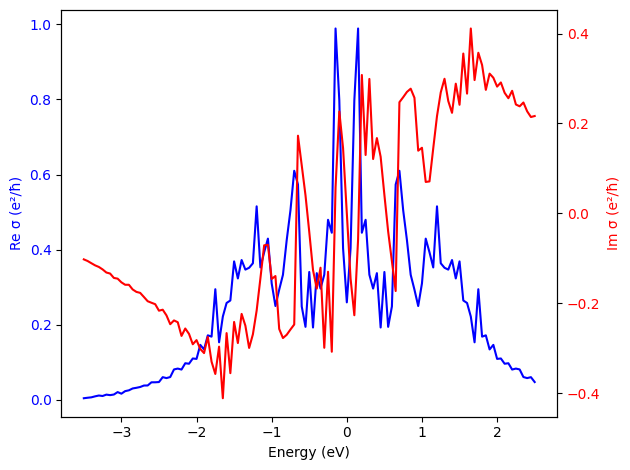

In [20]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

# Plot the real part on the first y-axis
ax1.plot(omegas, ac_cond.real, color='blue', label='Re σ')
ax1.set_xlabel("Energy (eV)")
ax1.set_ylabel("Re σ (e²/ħ)", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
ax2.plot(omegas, ac_cond.imag, color='red', label='Im σ')
ax2.set_ylabel("Im σ (e²/ħ)", color='red')
ax2.tick_params(axis='y', labelcolor='red')

fig.tight_layout()
plt.show()